In [8]:
#$ Imports
import os
import sys
import warnings
import json
from datetime import datetime

import numpy as np
from scipy import stats
import xarray as xr
import cftime
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from utils import helpers, settings
import utils
from utils import helpers

#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

warnings.filterwarnings('ignore')

In [9]:
plt.style.use('bmh')

In [10]:
ICOORD = 4710
lat, lon = utils.helpers.get_lat_lon_from_icoord(ICOORD)
lat, lon

(13.664921465968586, 145.0)

In [11]:
def get_preds(tau, icoord):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    path = os.path.join(PATHS['s2s_predictions'], f'tau_{tau}')

    residual_scaler = xr.open_dataset(os.path.join(path, 'residual_standardizer.nc'))
    
    target_z = xr.open_dataarray(os.path.join(path, 'target.nc'))
    pred_mean_z = xr.open_dataarray(os.path.join(path, 'pred_mean.nc'))
    pred_logvar_z = xr.open_dataarray(os.path.join(path, 'pred_logvar.nc'))
    pred_std_z = np.sqrt(np.exp(pred_logvar_z))
    pred_std_z = utils.processing.unstandardize(pred_std_z, residual_scaler)

    pred_mean_z = pred_mean_z.sel(lat=lat, lon=lon, method='nearest')
    pred_std_z = pred_std_z.sel(lat=lat, lon=lon, method='nearest')
    target_z = target_z.sel(lat=lat, lon=lon, method='nearest')
    
    return pred_mean_z, pred_std_z, target_z

In [12]:
def get_relevances_all_samples(tau, icoord, relevance_type='mean', relevance_method='ixg'):
    """
    Gets the relevances for all samples in the test set for a specific
    network (mean or std).
    """
    data_path = os.path.join(PATHS['full_globe'], 'data', f'tau_{tau}')
    network_path = os.path.join(PATHS['full_globe'], 'networks', f'tau_{tau}', f'loc_{icoord}')
    mean_configs = settings.configs['mean']
    residual_configs = settings.configs['residual']

    # Get inputs
    X_test_tensor = torch.load(os.path.join(data_path, 'X_test_tensor.pt'))
    n_inputs = X_test_tensor.shape[1]
    
    # Load model
    if relevance_type == 'mean':
        model = utils.networks.ANN(n_inputs, mean_configs)
        weights = torch.load(os.path.join(network_path, 'weights.pth'))
        model.load_state_dict(weights)

    elif relevance_type == 'std':
        model = utils.networks.residual_ANN(n_inputs, residual_configs)
        weights = torch.load(os.path.join(network_path, 'residual_weights.pth'))
        model.load_state_dict(weights)
    else:
        raise ValueError(f"Invalid relevance type {relevance_type}: should be 'mean' or 'std'")
    
    # Compute relevances
    if relevance_method == 'ixg':
        relevance = utils.xai.inputs_times_gradients(model, X_test_tensor)
    elif relevance_method == 'integrated_gradients':
        relevance = utils.xai.get_integrated_gradients(model, X_test_tensor, num_steps=10)
    else:
        raise ValueError(
            f"Invalid relevance method {relevance_method}: "
            "should be 'ixg' or 'integrated_gradients'"
        )

    # Convert relevances to xarray
    X_test_darray = utils.data.load_flattened_features(data_path, datatype='test')
    y_test = utils.data.load_flattened_targets(data_path, 'test')
    cftimes = utils.processing.datestrings_to_cftimeindex(y_test['time'].values, calendar='noleap')
    cftimes = xr.DataArray(cftimes, coords={'time': cftimes})

    relevance = xr.DataArray(relevance, dims=X_test_darray.dims, coords=X_test_darray.coords)
    relevance = (
        relevance
        .unstack(dim='s')
        .to_dataset(dim='var')
        .unstack(dim='sample')
        .squeeze(dim='member_id', drop=True)
    )
    relevance['time'] = cftimes

    return relevance

In [13]:
# Load standardized composite dataset
X = xr.open_dataset(os.path.join(PATHS['scratch'], 'xai', 'ds_test_standardized.nc'))
X = X.sel(lat=slice(-60,60))
X.load()

X_coarse = utils.data.load_coarsened_anomalies('zos', 5, 1301, '013')
X_coarse = X_coarse.sel(lat=slice(-60,60))

In [14]:
relevance_threshold_quantile = 0.95
likelihood_threshold = 0.80       # (1-alpha)
exceedance_value = 0

In [15]:
# Compute relevances
variables = ['SST', 'zos', 'UBOT', 'VBOT']
taus = [10, 20, 60, 120]

X_pos = xr.DataArray(
    np.empty((128, 288, 4, 4)),
    dims=('lat', 'lon', 'var', 'tau'),
    coords={'lat': X['lat'], 'lon': X['lon'], 'var': variables, 'tau': taus}
)
pos_relevances = xr.DataArray(
    np.empty((25, 72, 4, 4)),
    dims=('lat', 'lon', 'var', 'tau'),
    coords={'lat': X_coarse['lat'], 'lon': X_coarse['lon'], 'var': variables, 'tau': taus}
)

for j, tau in enumerate(tqdm([10, 20, 60, 120])):
    pred_mean_z, pred_std_z, target_z = get_preds(tau, ICOORD)
    relevances = get_relevances_all_samples(tau, ICOORD, relevance_type='mean', relevance_method='integrated_gradients')
    
    # Subset alpha% most-likely predictions and relevances
    prob_pos = xr.DataArray(
        stats.norm.sf((exceedance_value-pred_mean_z) / pred_std_z), coords={'time': pred_mean_z['time']}
    )
    likely_pos_times = prob_pos['time'].where(prob_pos >= np.quantile(prob_pos, likelihood_threshold), drop=True)

    # Times which result in actual positive anomalies
    truly_pos_times = target_z['time'].where(target_z > exceedance_value, drop=True)

    # Times which are predicted positive and are actually positive
    pos_times, _ = xr.align(likely_pos_times, truly_pos_times)

    X_pos[:, :, :, j] = X.sel(time=likely_pos_times.values).mean(dim='time').to_array().transpose('lat', 'lon', 'variable')
    pos_relevances[:, :, :, j] = relevances.sel(time=likely_pos_times.values).mean(dim='time').to_array().transpose('lat', 'lon', 'variable')

  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.55s/it]
2it [00:03,  1.59s/it]
3it [00:04,  1.22s/it]
4it [00:04,  1.02s/it]
5it [00:05,  1.10it/s]
6it [00:06,  1.20it/s]
7it [00:07,  1.26it/s]
8it [00:07,  1.31it/s]
9it [00:08,  1.36it/s]
10it [00:09,  1.10it/s]
 25%|██▌       | 1/4 [00:23<01:09, 23.30s/it]
0it [00:00, ?it/s]
1it [00:00,  1.56it/s]
2it [00:01,  1.52it/s]
3it [00:01,  1.51it/s]
4it [00:02,  1.51it/s]
5it [00:03,  1.51it/s]
6it [00:04,  1.46it/s]
7it [00:04,  1.44it/s]
8it [00:05,  1.45it/s]
9it [00:06,  1.48it/s]
10it [00:06,  1.48it/s]
 50%|█████     | 2/4 [00:43<00:42, 21.44s/it]
0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.51it/s]
3it [00:02,  1.49it/s]
4it [00:02,  1.47it/s]
5it [00:03,  1.47it/s]
6it [00:04,  1.46it/s]
7it [00:04,  1.45it/s]
8it [00:05,  1.48it/s]
9it [00:06,  1.51it/s]
10it [00:06,  1.49it/s]
 75%|███████▌  | 3/4 [01:03<00:20, 20.67s/it]
0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
2it [00:01,  1.37it/s]
3it [00:0

### Using contourf

CPU times: user 10.3 s, sys: 120 ms, total: 10.4 s
Wall time: 10.4 s


Text(0.5, 0.98, 'Composite inputs for 20% most-likely positive predictions')

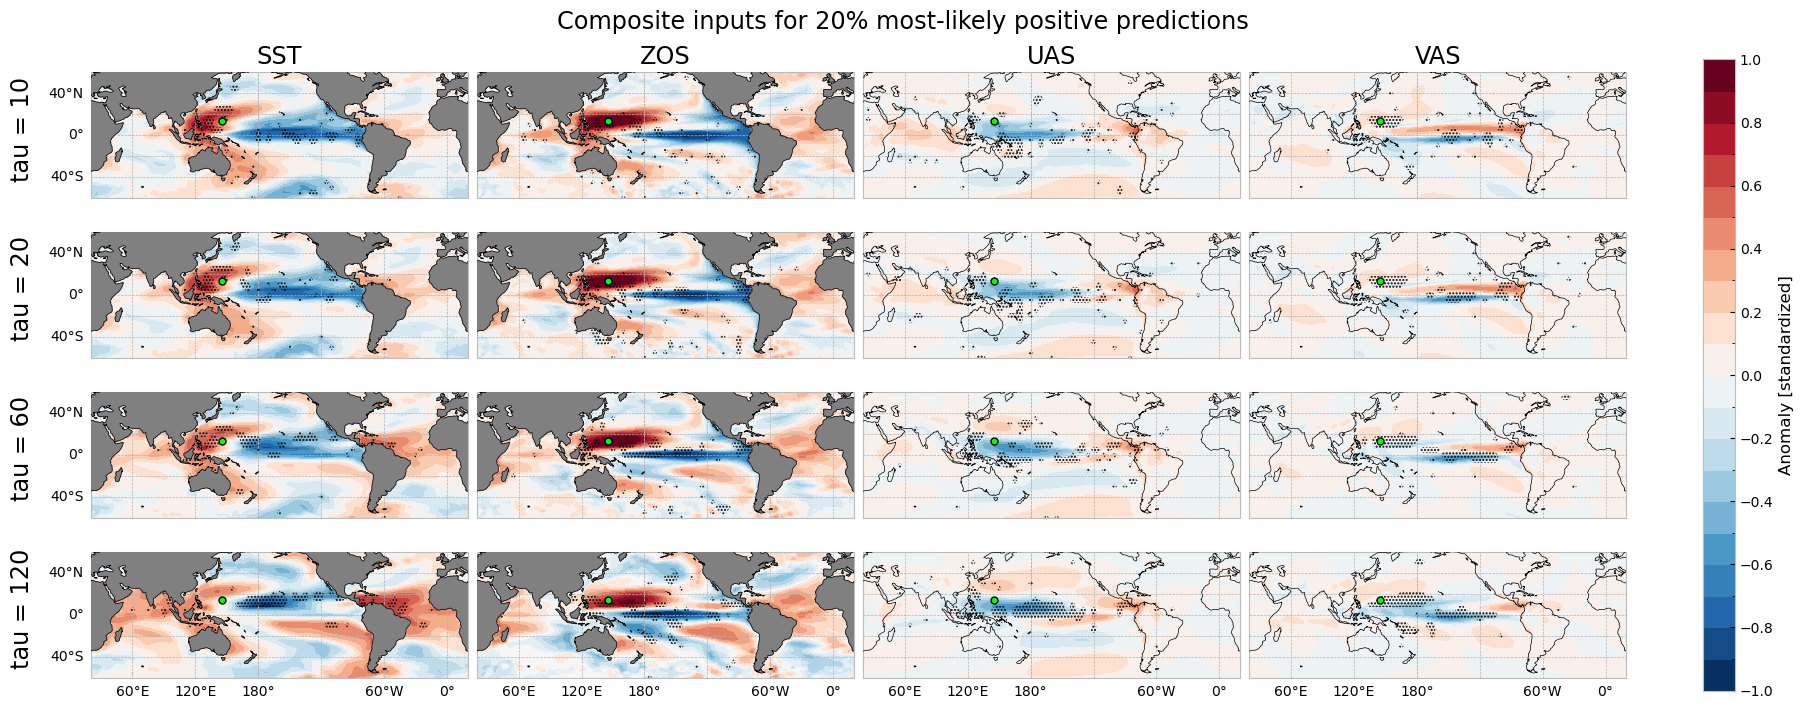

In [16]:
%%time
fig, axes = plt.subplots(
    figsize=(18,7), 
    ncols=4, nrows=4,
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    layout='constrained'
)

var_labels = ['SST', 'ZOS', 'UAS', 'VAS']
for i, tau in enumerate([10, 20, 60, 120]):
    # Plotting loop
    for j, var in enumerate(['SST', 'zos', 'UBOT', 'VBOT']):
        # Plot composites for likely positives
        cax = X_pos.sel(var=var, tau=tau).plot.contourf(
            ax=axes[i, j], 
            vmin=-1,
            vmax=1,
            levels=21,
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            zorder = 2
        )
        cax.set_edgecolor("face")
        
        # Relevance stippling
        relevance_threshold = (
            pos_relevances
           .sel(tau=tau, var=var)
           .quantile(relevance_threshold_quantile)
           .item()
        )
        sig_mask = pos_relevances.sel(tau=tau, var=var) >= relevance_threshold
    
        sig_mask.plot.contourf(
            ax=axes[i, j], 
            levels=3, 
            hatches=['', '.....'],
            colors='none', 
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            zorder=3
        )
        
        # Add point
        lat, lon = helpers.get_lat_lon_from_icoord(ICOORD)
        axes[i, j].plot(
            [lon], [lat],
            ls='', 
            marker='o',
            c='lime', 
            mec='k',
            ms=5,
            transform=ccrs.PlateCarree(),
            zorder=5
        )

        # Map elements
        axes[i, j].set_title(var_labels[j] if i==0 else '', fontsize='xx-large')
        # xlabel ylabel wont work with cartopy
        # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
        if j == 0:
            axes[i, j].text(
                -0.15, 0.55, f'tau = {tau}', 
                fontsize='xx-large', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=axes[i, j].transAxes
            )
        if j < 2:
            axes[i, j].add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5), zorder=4)
        axes[i, j].coastlines(zorder=4)
        gl = axes[i, j].gridlines()
        gl.left_labels = True if j==0 else False
        gl.bottom_labels = True if i==3 else False
        gl.right_labels = False
        gl.top_labels = False

cb = plt.colorbar(
    cax,
    ticks=np.linspace(-1,1,11),
    ax=axes,
    orientation='vertical',
    location='right', 
    label='Anomaly [standardized]'
)
cb.solids.set_edgecolor('face')

fig.suptitle(
    'Composite inputs for {:2.0%} most-likely positive predictions'.format(1-likelihood_threshold),
    fontsize='xx-large'
)

In [17]:
# For some reason have to do this twice or else it misses the ticklabel for 60° W
for i in range(4):
    for j in range(4):
        gl = axes[i, j].gridlines(zorder=5)
        gl.left_labels = True if j==0 else False
        gl.bottom_labels = True if i==3 else False
        gl.right_labels = False
        gl.top_labels = False

fig.savefig('changes_in_drivers_A.pdf', dpi=300, bbox_inches='tight')